# count most representative compounds in KEGG
housecleaning: pull out the pieces that can go somewhere else to get a 
clean version of the iPython notebook
4/12/2016 ; 4/15/2016

#Cell 14 is the place to change the path for the transcriptomics data...too big for GitHub

KL to do list: see B18/p94: make the plots not repeat isomers for the KEGG compounds, but present # of isomers

In [5]:
#%reset

In [6]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.cluster import KMeans
import cPickle as cpk

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio.KEGG.REST import *

%matplotlib inline

In [7]:
#corrected bug in MATLAB code that resulted in duplicate row numbers
mtabFile = 'RImetabolites_isomers.2016.09.01.csv' #first column is RInumber

In [8]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')

In [9]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [10]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut
##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut
##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut
##This will always be a single value, also uses CO_fromMATLAB as input 

In [11]:
#This grabs the CO/KO links from the KEGG website. The actual code is in the 
#CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv 
#file is a unique list of C number we essentially already have a lookup table 
#for all the metabolites of interest.

if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

In [22]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'

There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [23]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

In [25]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [26]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of days is useful, so define it up front.
dayList = ['S1','S2','S3','S4','S5'] 
CO_RawData_pruned = m.loc[:,dayList]
del m

In [27]:
#Load PhytoKEGG Annotations
#from Harriet...doesn't work, complaining about header=False 
#AllPhytoKO_ann=pd.read_table('AllPhytoKegg_annotated.tab', header=False, delimiter='\t')

#try this instead (note double \\ at end)
#pathToData = 'Z:\KLtemp\TranscriptomicsData_Feb2016\\'
pathToData = 'C:\Users\Krista\Documents\Current projects\Kujawinski_Metabolomics_RIsamples\TranscriptomicsData_Feb2016\\'
AllPhytoKO_ann=pd.read_table((pathToData + 'AllPhytoKegg_annotated.tab'), delimiter='\t')

InsituCounts=pd.read_table((pathToData + 'AllInsitu_NoZero.tab'), index_col='gID')

In [28]:
#normalize to the library size
InsituTPM=InsituCounts.copy()
InsituTPM[['S1', 'S2', 'S3', 'S4', 'S5']]=(InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']]/InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']].sum())*10**6

#Add annotation information
InsituCounts=InsituCounts.join(AllPhytoKO_ann)
InsituTPM=InsituTPM.join(AllPhytoKO_ann)
InsituCounts=InsituCounts.dropna()
InsituTPM=InsituTPM.dropna()

KO_RawData=InsituTPM.groupby('kID').sum()

In [29]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out

def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

In [30]:
#norm2Mean seems based (see plots in earlier notebooks)
KO_Norm2Mean=NormalizeToMean(KO_RawData) 

##two versions of the CO data: (1) regular and (2) inverse
CO_Norm2Mean_regular=NormalizeToMean(CO_RawData_pruned) 

In [31]:
#use _finalOption variable names to make life easier
KO_finalOption = KO_Norm2Mean.loc[AllKO].dropna()
CO_final_regular = CO_Norm2Mean_regular.dropna() #already 'limited' this before the normalization

In [ ]:
##Combine the CO and the KO data in preparation for K means clustering
#Combined_KO_CO_regular=KO_finalOption.append(CO_final_regular.loc[:,(dayList)])

In [32]:
CO_final_regular.head(4)

,S1,S2,S3,S4,S5
RInumber,,,,,
RI1,0.817390,1.677623,1.167981,0.749697,0.587309
RI2,0.532171,0.692874,0.355094,0.949504,2.470356
RI3,0.828302,1.119413,1.155018,0.611070,1.286197
RI4,1.071312,1.595462,0.975371,0.953067,0.404787


In [33]:
CO_final_regular.insert(0,'KEGG',"") #add a column called 'KEGG'

In [34]:
for idx in range(0,len(CO_final_regular)):
    t = CO_final_regular.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        CO_final_regular.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        CO_final_regular.ix[idx,('KEGG')] = t

In [35]:
oneCpd = 'C06030'
rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
len(rnList.splitlines())

2

In [36]:
uniqueCO = CO_final_regular['KEGG'].drop_duplicates()
countReactions = pd.DataFrame(uniqueCO)
countReactions.insert(1,'nReactions',"")
countReactions.insert(1,'nPathways',"")

In [37]:
#shorten for testing
#countReactions.drop(countReactions.index[[range(3,500)]], inplace = True)

In [38]:
for idx in range(0,len(countReactions)):
    #first figure out if this is a compound ...oops, can remove this bc only have compounds now
    #print countReactions.iloc[idx]
    oneCpd = countReactions.ix[idx,'KEGG']
    rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
    countReactions.ix[idx,'nReactions'] = len(rnList.splitlines())
    
    #now go count the pathways
    rnList = kegg_link('pathway',oneCpd).read()
    countReactions.ix[idx,'nPathways'] = len(rnList.splitlines())

In [39]:
countReactions.head(4)

,KEGG,nPathways,nReactions
RInumber,,,
RI1,C00047,15,39
RI2,C00078,21,27
RI3,C00079,21,31
RI6,C00082,32,33


In [40]:
#next will need to sort by number...have to go home now though

In [45]:
countReactions.sort_values(by = 'nReactions',ascending = False,inplace = True)

In [119]:
countReactions.head(6)

,KEGG,nPathways,nReactions
RInumber,,,
RI1625,C00019,11,432
RI1627,C00026,35,233
RI1626,C00020,22,216
RI1629,C00042,32,140
RI1628,C00031,31,113
RI1630,C00043,8,56


so...C00019 is SAM, C00026 is 2-oxoglurate, C00020 is AMP, C00042 is succinate, C00031 is glucose

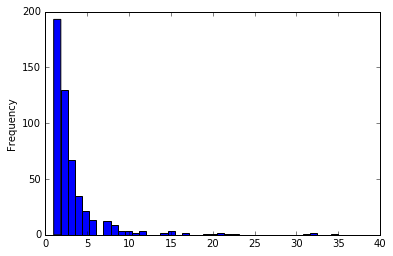

In [120]:
countReactions['nPathways'].plot(kind = 'hist',bins = 40)

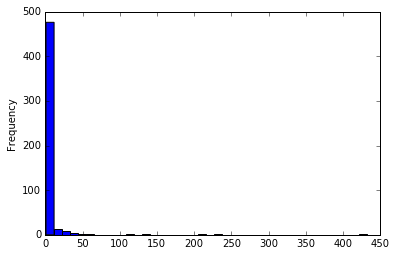

In [121]:
countReactions['nReactions'].plot(kind = 'hist',bins = 40)

In [122]:
oneCpd = 'C00026'

In [123]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('pathway',oneCpd).read() #now go get the compounds for that reaction
print len(rnList.splitlines())

35


In [124]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
print len(rnList.splitlines())

233


In [128]:
countReactions.head(5)

,KEGG,nPathways,nReactions
RInumber,,,
RI1625,C00019,11,432
RI1627,C00026,35,233
RI1626,C00020,22,216
RI1629,C00042,32,140
RI1628,C00031,31,113


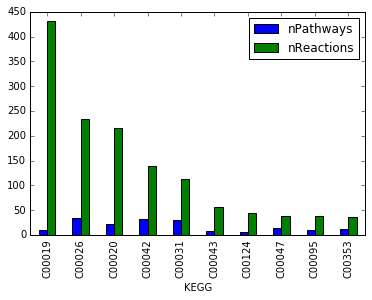

In [163]:
use = range(0,10)
labels = countReactions.ix[use,'KEGG']
tData = countReactions.ix[use]
ax = tData.plot(kind = 'bar',x = tData['KEGG'])
plt.savefig('topTen.png',bbox_inches='tight')

In [174]:
kegg_find('compound','C00353').read()

'cpd:C00353\tGeranylgeranyl diphosphate; Geranylgeranyl pyrophosphate; all-trans-Geranylgeranyl diphosphate; all-trans-Geranylgeranyl pyrophosphate; (2E,6E,10E)-3,7,11,15-Tetramethylhexadeca-2,6,10,14-tetraen-1-yl diphosphate\n'

In [126]:
#some other crazy ideas for plotting...leave here for now...

In [127]:
%debug #put here to force a stop...

> c:\anaconda\lib\site-packages\matplotlib\artist.py(237)axes()
    236                 (self._axes is not None and new_axes != self._axes)):
--> 237             raise ValueError("Can not reset the axes.  You are "
    238                              "probably trying to re-use an artist "

ipdb> quit


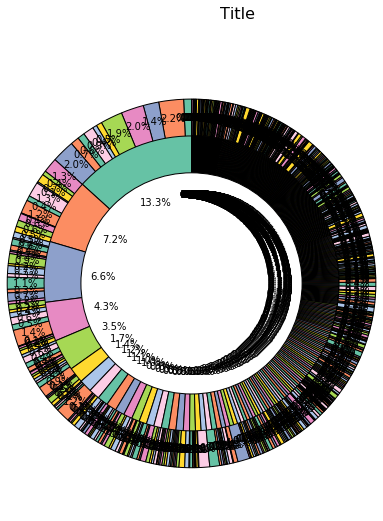

In [117]:
import matplotlib.pyplot as plt
from pylab import *

ioff() # don't show figures 

colors = [(102, 194, 165), (252, 141, 98), (141, 160, 203), (231, 138,195),  
          (166, 216, 84), (255, 217, 47), (171, 197, 233), (252, 205, 229)]

for icol in range(len(colors)):
    red,green,blue = colors[icol]
    colors[icol] = (red / 255., green / 255., blue / 255.)

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sizes_component_1 = countReactions.ix[range(0,len(countReactions)),'nPathways']
sizes_component_2 = countReactions.ix[range(0,len(countReactions)),'nReactions']

component_1 = 'exampleofalongtextthatiscutoff', '2', '3', '4','5'
component_2 = 'Unix', 'Mac', 'Windows7', 'Windows10', 'WindowsXP'

patches1, texts1, autotexts1 = ax.pie(sizes_component_1, radius=1, pctdistance=0.9, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
patches2, texts2, autotexts2 = ax.pie(sizes_component_2, radius=0.8, pctdistance=0.6, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)

# To draw circular donuts
ax.axis('equal')

# Draw white circle
centre_circle = plt.Circle((0,0),0.6,color='black', fc='white')         
ax.add_artist(centre_circle)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#lgd1=ax.legend(patches1,component_1, frameon=False, loc='center left', bbox_to_anchor=(1.0, 0.8), borderaxespad=0.1)
#lgd2=ax.legend(patches2,component_2, frameon=False, loc='center left', ncol=len(patches2)/2, bbox_to_anchor=(0.0, -0.005), borderaxespad=0)
#ax_elem = ax.add_artist(lgd1)

fig.suptitle('Title', fontsize=16)
fig.savefig('donut.png',bbox_extra_artists=(lgd1,lgd2,), bbox_inches='tight')
#plt.gcf().clear() # clears buffer

In [94]:
from bokeh.charts import Donut, show, output_file

if False: #only do reactions
    df = pd.DataFrame(countReactions.ix[range(0,len(countReactions)),('KEGG','nReactions')])
    df = df.sort("nReactions", ascending=False)

    df = pd.melt(df, id_vars=['KEGG'],
                 value_vars=['nReactions'],
                 value_name='group_count', var_name='group')

    d = Donut(df, label=['KEGG', 'group'], values='group_count',
              text_font_size='8pt', hover_text='group_count')
elif True:
    df = countReactions.ix[range(0,len(countReactions))]
    df = df.sort("nReactions", ascending=False)

    df = pd.melt(df, id_vars=['KEGG'],
                 value_vars=['nPathways', 'nReactions'],
                 value_name='group_count', var_name='group')

    d = Donut(df, label=['KEGG', 'group'], values='group_count',
              text_font_size='8pt', hover_text='group_count')


output_file("donut.html", title="donut.py example")

show(d)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
